# BBC News Multiclass

Dataset : https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive

In [1]:
import nltk, os, re, string
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Dataset/Submission/bbc_news_data.csv', sep='\t')
df_new = df.drop(columns=['filename'])
df_new

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,Be careful how you code,A new European directive could put software w...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...


In [4]:
df_new.title = df_new.title.apply(lambda x: x.lower())
df_new.content = df_new.content.apply(lambda x: x.lower())

def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    df_new.title = df_new.title.apply(lambda x: cleaner(x))
    df_new.content = df_new.content.apply(lambda x: lem(x))

lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    df_new.title = df_new.title.apply(lambda x: lem(x))
    df_new.content = df_new.content.apply(lambda x: lem(x))

def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    df_new['title'].apply(rem_numbers)
    df_new['content'].apply(rem_numbers)

st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    df_new.title = df_new.title.apply(lambda x: stopword(x))
    df_new.content = df_new.content.apply(lambda x: lem(x))

In [5]:
category = pd.get_dummies(df_new.category)
df_new_bbc = pd.concat([df_new, category], axis=1)
df_new_bbc = df_new_bbc.drop(columns='category')
df_new_bbc.head(10)

,title,content,business,entertainment,politics,sport,tech
0,ad sales boost time warner profit,quarterly profits at us media giant timewarne...,True,False,False,False,False
1,dollar gains on greenspan speech,the dollar has hit its highest level against ...,True,False,False,False,False
2,yukos unit buyer faces loan claim,the owners of embattled russian oil giant yuk...,True,False,False,False,False
3,high fuel prices hit ba's profits,british airways has blamed high fuel prices f...,True,False,False,False,False
4,pernod takeover talk lifts domecq,shares in uk drinks and food firm allied dome...,True,False,False,False,False
5,japan narrowly escapes recession,japan's economy teetered on the brink of a te...,True,False,False,False,False
6,jobs growth still slow in the us,the us created fewer jobs than expected in ja...,True,False,False,False,False
7,india calls for fair trade rules,"india, which attends the g7 meeting of seven ...",True,False,False,False,False
8,ethiopia's crop production up 24%,ethiopia produced 14.27 million tonnes of cro...,True,False,False,False,False
9,court rejects $280bn tobacco case,a us government claim accusing the country's ...,True,False,False,False,False


In [6]:
news = df_new_bbc['title'].values + '' + df_new_bbc['content'].values
label = df_new_bbc[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [7]:
news_train, news_test, label_train, label_test = train_test_split(news, label, test_size=0.2)

In [8]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(news_train)
tokenizer.fit_on_texts(news_test)

sequence_train = tokenizer.texts_to_sequences(news_train)
sequence_test = tokenizer.texts_to_sequences(news_test)

padded_train = pad_sequences(sequence_train)
padded_test = pad_sequences(sequence_test)

In [9]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0,5),
    Dense(5, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 109701 (428.52 KB)
Trainable params: 109701 (428.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nAkurasi Training dan Validation sudah mencapai > 90%!")
callbacks = myCallback()

In [11]:
history = model.fit(padded_train, label_train, epochs=50, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/50
56/56 - 267s - loss: 1.6022 - accuracy: 0.2062 - val_loss: 1.5865 - val_accuracy: 0.2247 - 267s/epoch - 5s/step
Epoch 2/50
56/56 - 245s - loss: 1.5551 - accuracy: 0.3292 - val_loss: 1.4611 - val_accuracy: 0.3169 - 245s/epoch - 4s/step
Epoch 3/50
56/56 - 239s - loss: 1.1706 - accuracy: 0.4472 - val_loss: 1.0379 - val_accuracy: 0.4494 - 239s/epoch - 4s/step
Epoch 4/50
56/56 - 242s - loss: 0.9216 - accuracy: 0.5556 - val_loss: 0.9875 - val_accuracy: 0.4697 - 242s/epoch - 4s/step
Epoch 5/50
56/56 - 243s - loss: 0.7434 - accuracy: 0.6247 - val_loss: 0.9116 - val_accuracy: 0.6022 - 243s/epoch - 4s/step
Epoch 6/50
56/56 - 244s - loss: 0.5070 - accuracy: 0.8331 - val_loss: 0.7077 - val_accuracy: 0.6742 - 244s/epoch - 4s/step
Epoch 7/50
56/56 - 241s - loss: 0.2525 - accuracy: 0.9315 - val_loss: 0.6783 - val_accuracy: 0.7573 - 241s/epoch - 4s/step
Epoch 8/50
56/56 - 245s - loss: 0.1583 - accuracy: 0.9500 - val_loss: 1.0728 - val_accuracy: 0.6180 - 245s/epoch - 4s/step
Epoch 9/50
56/56

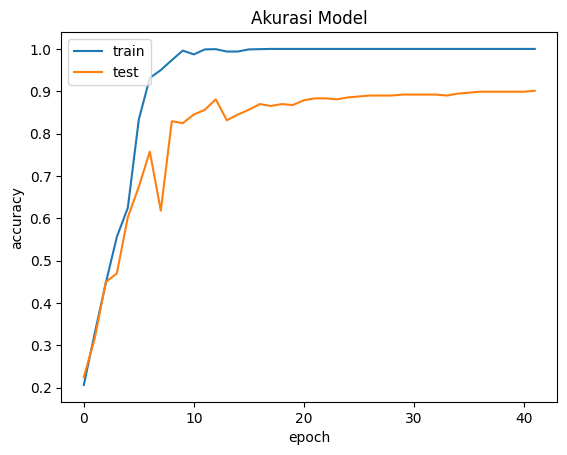

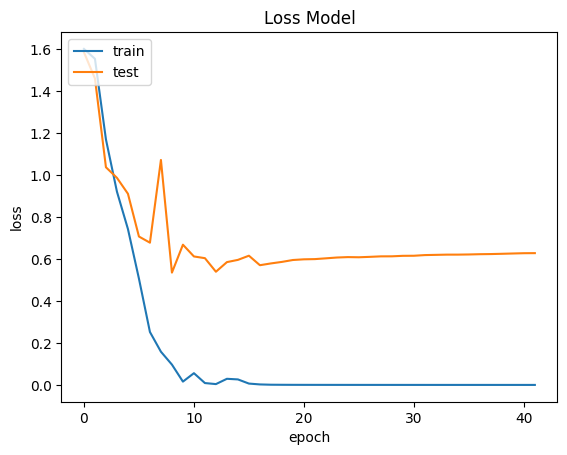

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()